# 🧮 Insurance Claims Triangle Analysis: Connor Chia
I will analyze multi-year claims triangle data using SQL and Python to simulate real-world actuarial skills.
In this project, my goals were to:
- Query triangle data using SQL
- Pivot it into triangle form
- Calculate link ratios
- Estimate ultimate claims
- Visualize the triangle as a heatmap

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the SQLite database
conn = sqlite3.connect('claims_triangle.db')

## 🔍 Step 1: View Raw Claims Triangle Data

In [4]:
query = "SELECT * FROM ClaimsTriangle ORDER BY AccidentYear, DevelopmentYear;"
pd.read_sql_query(query, conn)

,AccidentYear,DevelopmentYear,ReportedAmount
0,2018,0,26725.99
1,2018,1,21451.26
2,2018,2,7777.12
3,2018,3,4191.15
4,2018,4,660.98
5,2018,5,1269.55
6,2019,0,37783.57
7,2019,1,25188.20
8,2019,2,5597.41
9,2019,3,3973.32


## 📐 Step 2: Pivot into Triangle Format

In [5]:
triangle_df = pd.read_sql_query(query, conn)
triangle = triangle_df.pivot(index='AccidentYear', columns='DevelopmentYear', values='ReportedAmount')
triangle

DevelopmentYear,0,1,2,3,4,5
AccidentYear,,,,,,
2018,26725.99,21451.26,7777.12,4191.15,660.98,1269.55
2019,37783.57,25188.20,5597.41,3973.32,2351.85,NaN
2020,33457.63,7856.27,7552.57,2217.59,NaN,NaN
2021,44995.22,14213.78,6269.30,NaN,NaN,NaN
2022,54175.61,13198.84,NaN,NaN,NaN,NaN
2023,24262.84,NaN,NaN,NaN,NaN,NaN


A claims triangle is a structured table used in insurance to track how claims for each accident year develop over time. Rows represent the year in which claims occurred (accident year), and columns represent the number of years since the claim occurred (development year). Each cell shows the cumulative amount of claims reported or paid by that development year. This triangular format allows actuaries to analyze patterns in claim development and project future claims, which is essential for estimating reserves like IBNR (Incurred But Not Reported).

# Why We Do This:

This pivoted format is essential for actuarial techniques like:
- Chain-Ladder
- Bornhuetter-Ferguson
- Development factor projections

These methods rely on:
- Looking across columns to compute how claims grow from one year to the next
- Projecting the missing (future) parts of the triangle
- Estimating ultimate losses and IBNR (Incurred But Not Reported)

Without the pivot, the data is just a flat list — not useful for trend and development analysis.

## 📈 Step 3: Calculate Link Ratios (Age-to-Age Factors)

In [6]:
link_ratios = triangle.shift(-1, axis=1) / triangle
link_ratios = link_ratios.iloc[:, :-1]
link_ratios

DevelopmentYear,0,1,2,3,4
AccidentYear,,,,,
2018,0.802637,0.362548,0.538908,0.157709,1.920709
2019,0.666644,0.222224,0.709850,0.591911,NaN
2020,0.234813,0.961343,0.293621,NaN,NaN
2021,0.315895,0.441072,NaN,NaN,NaN
2022,0.243631,NaN,NaN,NaN,NaN
2023,NaN,NaN,NaN,NaN,NaN


In this step, we're calculating link ratios (also known as development factors) from the claims triangle. These ratios represent how claims grow from one development year to the next within each accident year. To do this, we shift the triangle one column to the left so that each value lines up with the value from the following development year, then divide the shifted values by the original triangle values. This gives us a matrix of growth factors between successive development years. Finally, we remove the last column, which contains invalid values due to the shift. These link ratios are essential for projecting future claims and estimating total reserves using methods like the Chain-Ladder technique.

# Why We Do This: 

We calculate link ratios to understand how claims grow from one development year to the next. These ratios are the backbone of the Chain-Ladder method, which uses historical development patterns to project future claims and estimate ultimate losses. By averaging these link ratios, actuaries can fill in the missing parts of the triangle.

## 📊 Step 4: Average Link Ratios

In [7]:
avg_link_ratios = link_ratios.mean()
avg_link_ratios

DevelopmentYear
0    0.452724
1    0.496797
2    0.514126
3    0.374810
4    1.920709
dtype: float64

## 🔮 Step 5: Estimate Ultimate Claims

In [8]:
latest_triangle = triangle.copy()
for col in range(latest_triangle.shape[1], 6):
    latest_triangle[col] = np.nan
for i in range(len(latest_triangle)):
    for j in range(1, 6):
        if pd.isna(latest_triangle.iloc[i, j]):
            latest_triangle.iloc[i, j] = latest_triangle.iloc[i, j - 1] * avg_link_ratios[j - 1]
latest_triangle = latest_triangle.round(2)
latest_triangle

DevelopmentYear,0,1,2,3,4,5
AccidentYear,,,,,,
2018,26725.99,21451.26,7777.12,4191.15,660.98,1269.55
2019,37783.57,25188.20,5597.41,3973.32,2351.85,4517.22
2020,33457.63,7856.27,7552.57,2217.59,831.17,1596.44
2021,44995.22,14213.78,6269.30,3223.21,1208.09,2320.39
2022,54175.61,13198.84,6557.14,3371.20,1263.56,2426.92
2023,24262.84,10984.37,5457.00,2805.58,1051.56,2019.74


In this step, we are completing the claims triangle by projecting future claim amounts using the previously calculated average link ratios. First, empty columns (filled with NaN) are added to extend the triangle to six development years. Then, for each missing value in the triangle, we multiply the previous year's claim amount by the corresponding average link ratio to estimate the next year's value. This iterative process fills in the lower triangle, allowing us to estimate ultimate claims for each accident year. Finally, the values are rounded for presentation.

# Why We Do This:

- To estimate future claims: Many claims develop over multiple years; projecting allows us to estimate those still outstanding.
- To calculate ultimate claims: Filling in the full triangle helps determine the total expected cost of claims for each accident year.
- To estimate reserves: The difference between projected ultimate claims and reported claims gives us IBNR (Incurred But Not Reported) reserves.
- To apply actuarial methods: Techniques like the Chain-Ladder method require a fully populated triangle to work properly.
- To support financial reporting: Insurance companies need complete estimates of future liabilities for regulatory, solvency, and financial reporting purposes.

## 🌡️ Step 6: Visualize as Heatmap

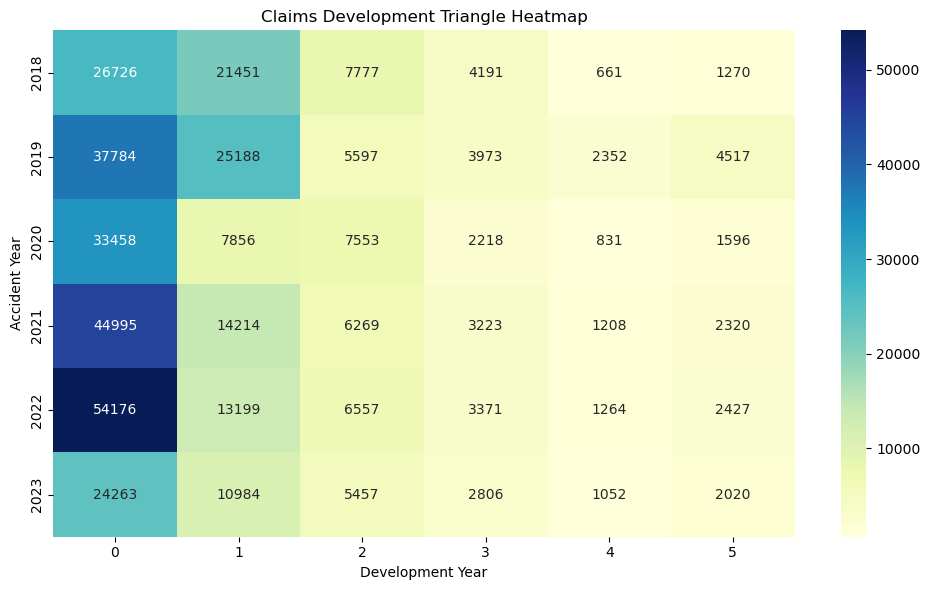

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(latest_triangle, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Claims Development Triangle Heatmap")
plt.xlabel("Development Year")
plt.ylabel("Accident Year")
plt.tight_layout()
plt.show()

# Why We Do This:

We create a heatmap of the completed claims triangle for several key reasons:
- To visualize the data clearly: A heatmap makes it easier to spot trends, patterns, and anomalies in claim development across years.
- To verify projections: It helps us visually confirm that the projected values follow a logical progression, based on historical patterns.
- To communicate results: Visuals are more intuitive and easier to interpret than raw numbers, especially for stakeholders without a technical background.
- To identify outliers: Sharp jumps or inconsistencies in claim amounts stand out in a heatmap and can prompt further investigation.
- To support decision-making: Clear visuals aid actuaries, underwriters, and executives in understanding reserve levels and making informed decisions.

## ✅ Done!

In [11]:
conn.close()